# Addestramento di Mario con PPO
Questo notebook è diviso in quattro macro aree:
1. **Setup Mario**: Configura il gioco e le librerie necessarie.
2. **Preprocess Environment**: Applica preprocessamenti sull'ambiente.
3. **Train the RL Model**: Addestra il modello utilizzando Proximal Policy Optimization (PPO).
4. **Test it Out**: Valuta il modello addestrato nel gioco.

# 1. Setup Mario

In [ ]:
# Installazioni (opzionale, eseguire solo se necessario)
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra]

In [1]:
# Importa il gioco
import gym_super_mario_bros
# Importa il wrapper per il Joypad
from nes_py.wrappers import JoypadSpace
# Importa i controlli SEMPLIFICATI
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# Libreria per la GPU
import torch

print("Setup completato correttamente.")

c:\Users\marco\Desktop\Marco\Universita\Magistrale\IA\prog\mario_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup completato correttamente.


In [2]:
# Configura il dispositivo per l'addestramento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Addestramento sul dispositivo: {device}")

Addestramento sul dispositivo: cuda


# 2. Preprocess Environment

In [3]:
# Importa il wrapper per l'accumulo dei frame e il wrapper per la conversione in scala di grigi
from gym.wrappers import GrayScaleObservation
# Importa i wrapper per la vettorizzazione
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Importa Matplotlib per mostrare l'impatto dell'accumulo dei frame
from matplotlib import pyplot as plt

In [4]:
# 1. Crea l'ambiente base
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Semplifica i controlli
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Converti in scala di grigi
env = GrayScaleObservation(env, keep_dim=True)
# 4. Inserisci l'ambiente all'interno del Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Accumula i frame
env = VecFrameStack(env, 4, channels_order='last')

print("Preprocessing dell'ambiente completato.")

Preprocessing dell'ambiente completato.


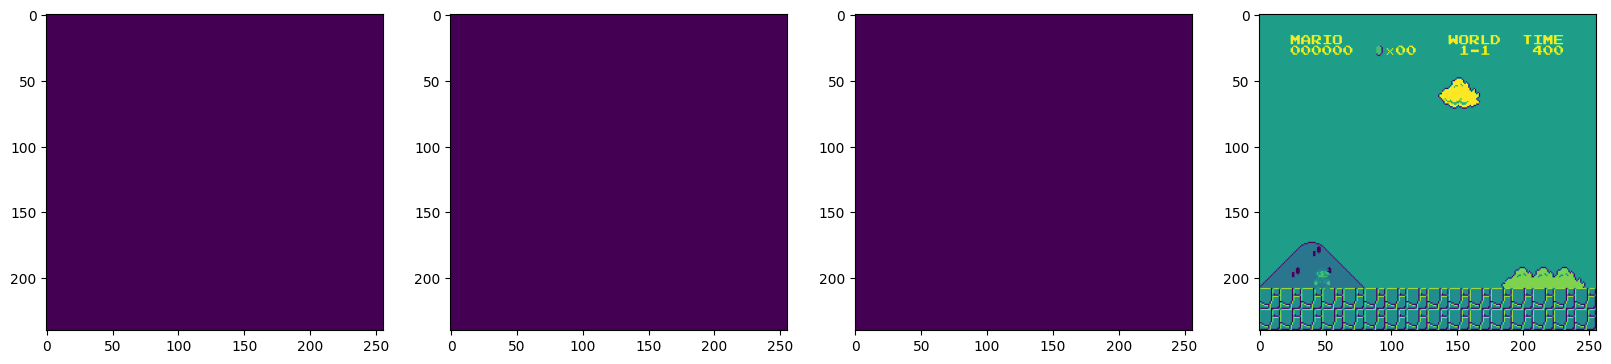

In [5]:
# Visualizza lo stato
state = env.reset()
plt.figure(figsize=(20, 16))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(state[0][:, :, idx])
plt.show()

# 3. Train the RL Model

In [6]:
# Importa os per la gestione dei percorsi dei file
import os 
# Importa PPO per gli algoritmi
from stable_baselines3 import PPO
# Importa Base Callback per salvare i modelli
from stable_baselines3.common.callbacks import BaseCallback

In [7]:
# Definisci il callback per il salvataggio del modello
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
            self.model.save(model_path)
            print(f"Checkpoint salvato a: {model_path}")
        return True

# Configura i percorsi e il callback
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [8]:
# Configura il modello
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000005, n_steps=2048, device=device)
print("Modello configurato correttamente.")

Using cuda device
Wrapping the env in a VecTransposeImage.
Modello configurato correttamente.


In [9]:
# Addestra il modello
try:
    model.learn(total_timesteps=10000000, callback=callback)
    model.save('./train/final_model')
    print("Addestramento completato con successo.")
except KeyboardInterrupt:
    print("Addestramento interrotto manualmente. Salvando il modello attuale...")
    model.save('./train/interrupt_checkpoint')

Logging to ./logs/PPO_1


c:\Users\marco\Desktop\Marco\Universita\Magistrale\IA\prog\mario_env\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-----------------------------
| time/              |      |
|    fps             | 121  |
|    iterations      | 1    |
|    time_elapsed    | 16   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002054549 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | -6.32e-05   |
|    learning_rate        | 5e-06       |
|    loss                 | 36.9        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00186    |
|    value_loss           | 122         |
-----------------------------------------
----------------------------------

# 4. Test it Out

In [ ]:
# Carica il modello
model = PPO.load('./train/best_model_10000000')

In [ ]:
# Reimposta l'ambiente
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [11]:
state = env.reset()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Inizializza contatori e variabili
episode = 0
victories = 0
last_world = 1
last_stage = 1
initial_lives = 3
fall_threshold = 5  # Soglia per identificare una caduta

# Ciclo per il gioco
while episode < 1000:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

    # Controlla la posizione corrente
    current_y_pos = info[0].get("y_pos", 79)
    current_lives = info[0].get("life", initial_lives)

    #controllo della caduta
    if current_y_pos < fall_threshold:
        episode += 1
        state = env.reset()
        continue

    # Verifica perdita di vita
    if current_lives < initial_lives:
        episode += 1
        initial_lives = current_lives
        state = env.reset()
        continue

    # Controlla se il gioco è terminato
    if done:
        episode += 1
        
        current_world = info[0].get("world", 1)
        current_stage = info[0].get("stage", 1)
        
        # Controlla se Mario ha completato un livello
        if (current_world > last_world) or (current_stage > last_stage):
            victories += 1
            print(f"Vittoria nell'episodio {episode}! Ora Mario è nel mondo {current_world}-{current_stage}.")
        
        # Aggiorna i valori di mondo e stage
        last_world = current_world
        last_stage = current_stage
        
        # Reimposta l'ambiente per il prossimo episodio
        state = env.reset()

# Fine del test dopo 1000 episodi
print(f"Test completato. Vittorie totali: {victories} su {episode} episodi.")
env.close()
